Problem
Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units (nn.relu()) and 1024 hidden nodes. This model should improve your validation / test accuracy.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import random

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

  test_labels_without_reformat = test_labels.copy()

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


So going though the lectures again I feel that the solution for this problem would be by adding the relu into the Logits. 

### Input layer 

` input_layer = x*W + Bias ` Where the final dimensions are 128 x 10, W : 784 x 10 ; B : 1 x 10

### Hidden Layer 

` hidden_layer = relu(input_layer) Wh + Bh ` Where the Dimensions of Wh are 10 x 1000 and Bh are 1 x 1000, final
dimensions are 128 x 1000

### Output Layer

` output_layer = relu(hidden_layer) Wo + Bo ` Where the Dimensions of Wo are 1000 x 10 and Bo are 1 x 10, final dimensions are 128 x 10

In [4]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape,stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  #initial = tf.zeros(shape)
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def prediction_function(dataset,W_i,B_i,W_h,B_h,W_o,B_o):
    return tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(dataset,W_i) + B_i),W_h) + B_h),W_o) + B_o)  

In [5]:
batch_size = 128
image_size = 28
num_labels = 10
hidden_layer_count = 1024
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    ##################################
    # Input Layer
    ##################################
    # Variables
    W_i = weight_variable([image_size*image_size,num_labels])
    B_i = bias_variable([num_labels])
    
    # Training computation    
    input_logit = tf.matmul(tf_train_dataset,W_i) + B_i
    
    ##################################
    # Hidden Layer
    ##################################
    # Variables
    W_h = weight_variable([num_labels,hidden_layer_count])
    B_h = bias_variable([hidden_layer_count])
    
    # Training computation    
    hidden_logit = tf.matmul(tf.nn.relu(input_logit),W_h) + B_h
    
    ##################################
    # Output Layer
    ##################################
    # Variables
    W_o = weight_variable([hidden_layer_count,num_labels])
    B_o = bias_variable([num_labels])
    
    # Training computation    
    output_logit = tf.matmul(tf.nn.relu(hidden_logit),W_o) + B_o  
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output_logit, tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Function for prediction
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(output_logit)
    valid_prediction = prediction_function(tf_valid_dataset,W_i,B_i,W_h,B_h,W_o,B_o)
    test_prediction = prediction_function(tf_test_dataset,W_i,B_i,W_h,B_h,W_o,B_o)
    
    

In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [7]:
num_steps = 3000

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  pred_list = test_prediction.eval()
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels.copy()))

Initialized
Minibatch loss at step 0: 2.389378
Minibatch accuracy: 7.0%
Validation accuracy: 14.9%
Minibatch loss at step 500: 0.460418
Minibatch accuracy: 85.9%
Validation accuracy: 82.8%
Minibatch loss at step 1000: 0.481364
Minibatch accuracy: 85.9%
Validation accuracy: 83.1%
Minibatch loss at step 1500: 0.409366
Minibatch accuracy: 86.7%
Validation accuracy: 83.4%
Minibatch loss at step 2000: 0.584312
Minibatch accuracy: 79.7%
Validation accuracy: 83.4%
Minibatch loss at step 2500: 0.501343
Minibatch accuracy: 83.6%
Validation accuracy: 84.1%
Test accuracy: 90.6%


Confusion Matrix : 
[[ 921.    7.    2.    2.    4.    9.    7.   31.    8.    9.]
 [   6.  914.    3.   11.   14.   10.   11.   15.   10.    6.]
 [   3.    2.  902.    2.   43.   11.   18.    5.   14.    0.]
 [   7.   54.    4.  880.    3.    6.    6.    5.   13.   22.]
 [   5.   15.   14.    1.  889.   22.   12.   10.   26.    6.]
 [   4.    3.    2.    3.    6.  943.    6.    3.   18.   12.]
 [   9.   10.   18.    2.   10.   27.  904.    8.    5.    7.]
 [  16.   15.    3.    1.    3.   11.   10.  912.   26.    3.]
 [   8.    8.    3.    9.    9.   15.   12.   15.  873.   48.]
 [   6.    7.    0.    3.    5.    8.    8.    4.   36.  923.]]


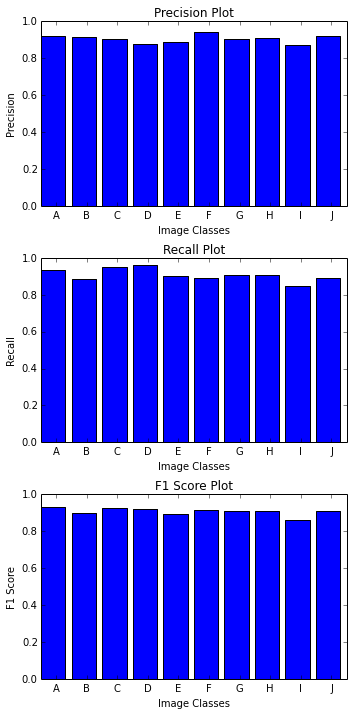

In [8]:
def confusion_matrix(ori_labels, pred_labels):
    confision_matrix = np.zeros((10, 10))
    for ori_lab, pred_lab in zip(ori_labels, pred_labels):
        confision_matrix[ori_lab, pred_lab] += 1
    return confision_matrix

def recall(confusion_mat,lab):
    #print("True Positives : {} \nTrue Positives + False Negetives : {}".format(confusion_mat[lab,lab],np.sum(confusion_mat[:,lab])))
    rec = confusion_mat[lab,lab]/np.sum(confusion_mat[:,lab])
    #print("Recall for class {} : {}".format(lab,rec))
    return rec

def precision(confusion_mat,lab):
    #print("True Positives : {} \nTrue Positives + False Positives : {}".format(confusion_mat[lab,lab],np.sum(confusion_mat[lab,:])))
    prec = confusion_mat[lab,lab]/np.sum(confusion_mat[lab,:])
    #print("Precision for class {} : {}".format(lab,prec))
    return prec

def f1_score(confusion_mat,lab):
    return 2*(precision(confusion_mat,lab)*recall(confusion_mat,lab)) / (precision(confusion_mat,lab) + recall(confusion_mat,lab))

def plot_recall_n_precision(confusion_mat):
    """
    Check the number of images under each class or label
    and plot a histogram to see if the dataset is balanced
    """
    print("Confusion Matrix : \n{}".format(confusion_mat))
    recall_list = [recall(confusion_mat,x) for x in range(10)]
    precision_list = [precision(confusion_mat,x) for x in range(10)]
    f1score_list = [f1_score(confusion_mat,x) for x in range(10)]
    
    plt.figure()
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
    #print(axes) 
    axes[0].bar(range(10),precision_list)
    labels = string.uppercase[:10]
    axes[0].set_xticks([x + 0.5 for x in range(10)])
    axes[0].set_xticklabels(labels)
    axes[0].set_ylabel('Precision')
    axes[0].set_xlabel('Image Classes')
    axes[0].set_title('Precision Plot')
    
    axes[1].bar(range(10),recall_list)
    axes[1].set_xticks([x + 0.5 for x in range(10)])
    axes[1].set_xticklabels(labels)
    axes[1].set_ylabel('Recall')
    axes[1].set_xlabel('Image Classes')
    axes[1].set_title('Recall Plot')
    
    axes[2].bar(range(10),f1score_list)
    axes[2].set_xticks([x + 0.5 for x in range(10)])
    axes[2].set_xticklabels(labels)
    axes[2].set_ylabel('F1 Score')
    axes[2].set_xlabel('Image Classes')
    axes[2].set_title('F1 Score Plot')
    
    fig.tight_layout()
    plt.show()

plot_recall_n_precision(confusion_matrix(test_labels_without_reformat,[x for x in np.argmax(pred_list, 1)]))